In [2]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import sys
import os
from matplotlib import pyplot as plt
import pickle
from climtools import climtools_lib as ctl
from scipy import stats
import xarray as xr
import glob
#import pymannkendall as mk

plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
titlefont = 22
plt.rcParams['figure.titlesize'] = titlefont
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['legend.fontsize'] = 18

#############################################################################

cart_out = '/home/fabiano/Research/lavori/BOTTINO/nonlin_evol_1000/'

colors = ['black', 'royalblue', 'lightslategray', 'forestgreen', 'orange', 'chocolate', 'maroon', 'violet', 'crimson']
allru = ['pi', 'hist', 'b990', 'b025', 'b050', 'b065', 'b080', 'b100', 'ssp585']

No DISPLAY variable set. Switching to agg backend


In [3]:
cart_in = '/home/fabiano/Research/lavori/BOTTINO/seasmean/'
gogo = pickle.load(open(cart_in + 'bottino_glomeans_1000.p', 'rb'))
glomeans, pimean = gogo

In [4]:
%matplotlib inline

In [5]:
fluxes = pickle.load(open(cart_out + 'fluxes_all.p', 'rb'))

In [6]:
[ke for ke in fluxes.keys() if 'b050' in ke]

[('b050', 'tas'),
 ('b050', 'net_toa'),
 ('b050', 'net_toa_corr'),
 ('b050', 'net_srf_oce'),
 ('b050', 'atm_imb'),
 ('b050', 'oce_imb')]

b990
b990: $\lambda = -0.632 \pm 0.242 \ W/m^2/K$
b025
b025: $\lambda = -0.632 \pm 0.307 \ W/m^2/K$
b050
b050: $\lambda = -0.902 \pm 0.202 \ W/m^2/K$
b065
b065: $\lambda = -1.201 \pm 0.198 \ W/m^2/K$
b080
b080: $\lambda = -1.181 \pm 0.285 \ W/m^2/K$
b100
b100: $\lambda = -0.829 \pm 0.171 \ W/m^2/K$


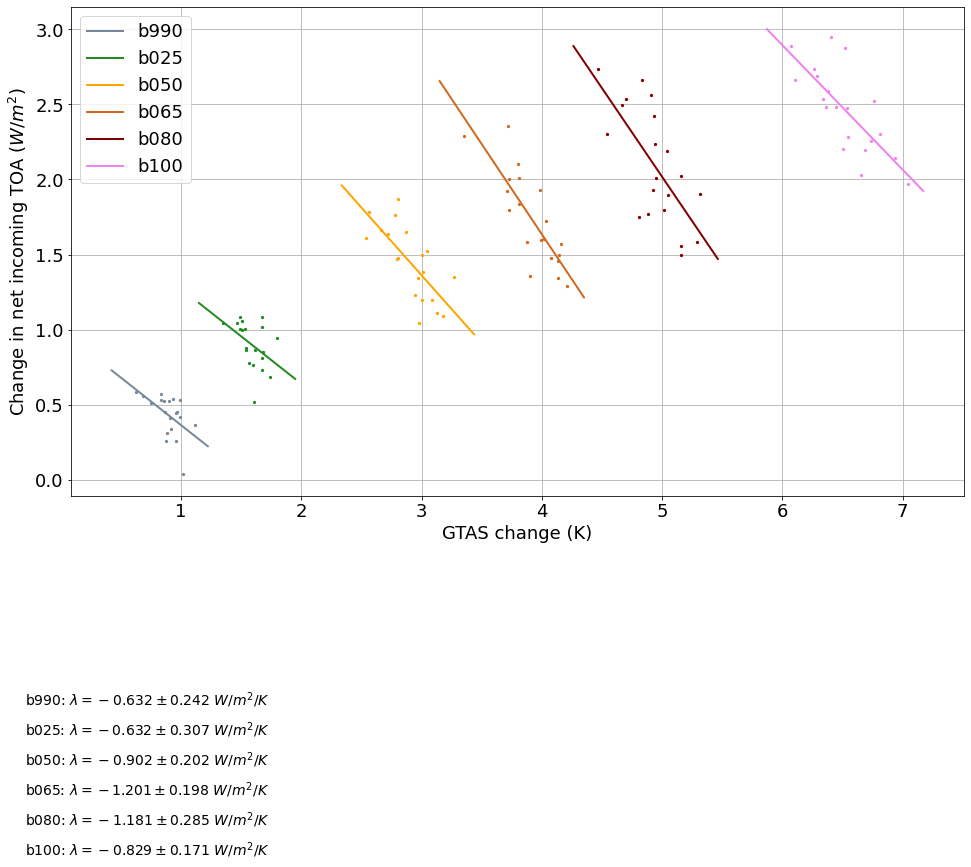

In [7]:
var = 'net_toa'
nx = 1

fb_start20 = dict()

init = 0
fin = 20

fig, ax = plt.subplots(figsize = (16,9))

for ru, col in zip(allru[2:-1], colors[2:-1]):
    print(ru)
    #toa = glomeans[(ru, var)][1][init:fin]
    toa = fluxes[(ru, 'net_toa_corr')][init:fin]
    toa_anom = toa#-np.mean(toa[:10])
    #toa_anom = ctl.running_mean(toa_anom, 5, remove_nans = True)[::5]

    # tas = glomeans[(ru, 'tas')][1][init:fin]
    tas = fluxes[(ru, 'tas')][init:fin]
    tas_anom = tas #- tas[:10].mean()
    #tas_anom = ctl.running_mean(tas_anom, 5, remove_nans = True)[::5]

    # ordering for temp # NO! this is different than removing the fast manifold
    #gino = np.argsort(tas_anom)
    #tas_anom = tas_anom[gino]
    #toa_anom = toa_anom[gino]

    toa_anom = np.mean(np.split(toa_anom, int(len(toa_anom)/nx)), axis = 1)
    tas_anom = np.mean(np.split(tas_anom, int(len(tas_anom)/nx)), axis = 1)
    ax.scatter(tas_anom, toa_anom, color = col, s = 5)

    x_nu = np.arange(tas_anom.min()-0.2, tas_anom.max()+0.2, 0.1)
    # coeffs2, covmat = np.polyfit(tas_anom, toa_anom, deg = 2, cov = True)
    # toaint(coeffs2)
    # fitted = np.polyval(coeffs2, x_nu)
    # ax.plot(x_nu, fitted, color = col, ls = ':')

    coeffs, covmat = np.polyfit(tas_anom, toa_anom, deg = 1, cov = True)
    fitted = np.polyval(coeffs, x_nu)
    ax.plot(x_nu, fitted, color = col, lw = 2, label = ru)

    x_nu_ok = x_nu #+ tas[:10].mean() #- pimean['tas']
    # ax2.plot(x_nu_ok, coeffs2[1]+2*coeffs2[0]*x_nu, color = col, lw = 2, label = ru)

    m, c, err_m, err_c = ctl.linear_regre_witherr(tas_anom, toa_anom)
    stron = r'{}: $\lambda = {:5.3f} \pm {:5.3f} \ W/m^2/K$'.format(ru, m, err_m)
    print(stron)
    ax.text(-0.3, -1.5-(allru.index(ru)-2)*0.2, stron, fontsize = 14)

    fb_start20[ru] = (m, err_m)

ax.grid()
ax.legend()
#ctl.custom_legend(fig, colors[2:-1], allru[2:-1])
#ax.subplots_adjust(bottom = 0.2)
ax.set_xlabel('GTAS change (K)')
ax.set_ylabel(r'Change in net incoming TOA ($W/m^2$)')
fig.savefig(cart_out + 'feedback_evolution_0-20.pdf'.format(var))

### Note Fig. 5 Paper

- la fig. della versione 2 è ottenuta con: var = net_toa, nx = 5 (contrariamente a quanto viene detto nei metodi)
- la cosa corretta è usare: var = net_toa_corr. piccoli cambiamenti (lambda si riduce un po', il max è di circa 0.5 per b100)
- usando nx = 10 cambiano piccole cose, tra cui il fastidioso feedback della seconda metà di b025.. niente di grave cmq

b990: $\lambda = -0.260 \pm 0.057 \ W/m^2/K$
b025: $\lambda = -0.489 \pm 0.025 \ W/m^2/K$
b050: $\lambda = -0.566 \pm 0.022 \ W/m^2/K$
b065: $\lambda = -0.544 \pm 0.023 \ W/m^2/K$
b080: $\lambda = -0.560 \pm 0.012 \ W/m^2/K$
b100: $\lambda = -0.644 \pm 0.012 \ W/m^2/K$


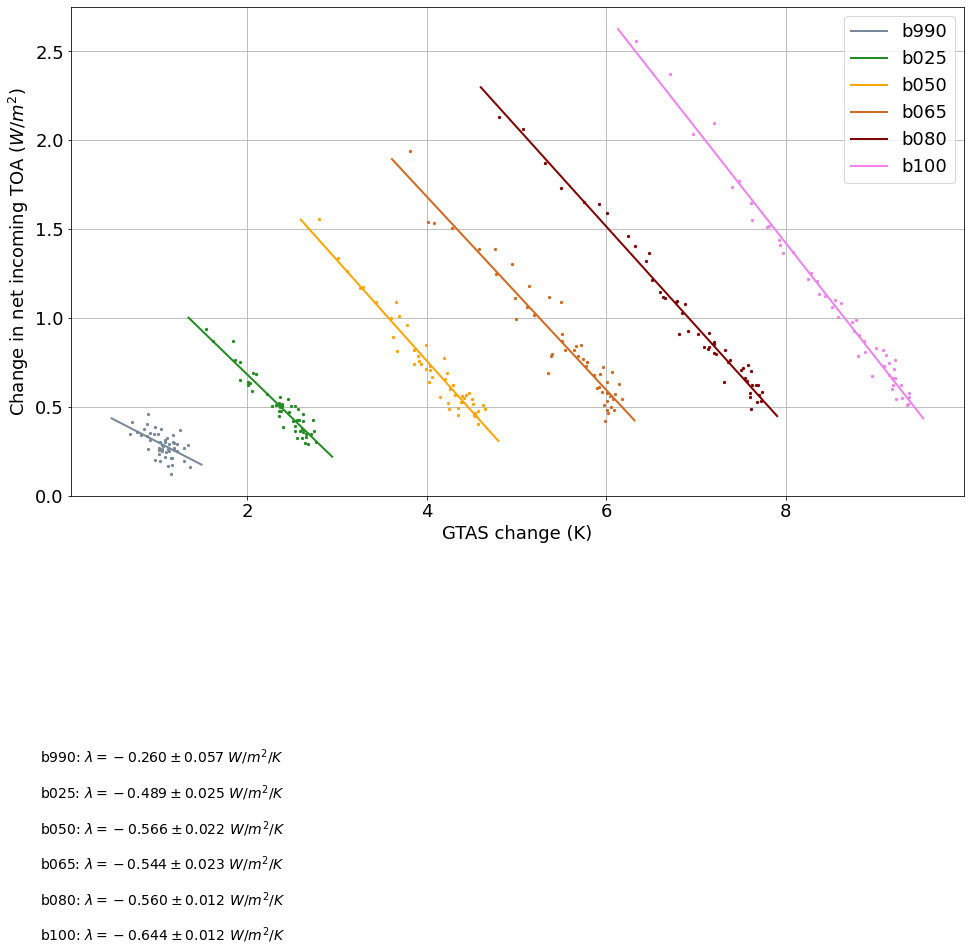

In [11]:
var = 'net_toa_corr'
nx = 10
fb_init = dict()

init = 0
fin = 500

fig, ax = plt.subplots(figsize = (16,9))

for ru, col in zip(allru[2:-1], colors[2:-1]):
    #toa = glomeans[(ru, var)][1][init:fin]
    toa = fluxes[(ru, var)][init:fin]
    toa_anom = toa#-np.mean(toa[:10])
    #toa_anom = ctl.running_mean(toa_anom, 5, remove_nans = True)[::5]

    #tas = glomeans[(ru, 'tas')][1][init:fin]
    tas = fluxes[(ru, 'tas')][init:fin]
    tas_anom = tas #- tas[:10].mean()
    #tas_anom = ctl.running_mean(tas_anom, 5, remove_nans = True)[::5]

    # ordering for temp # NO! this is different than removing the fast manifold
    #gino = np.argsort(tas_anom)
    #tas_anom = tas_anom[gino]
    #toa_anom = toa_anom[gino]

    toa_anom = np.mean(np.split(toa_anom, int(len(toa_anom)/nx)), axis = 1)
    tas_anom = np.mean(np.split(tas_anom, int(len(tas_anom)/nx)), axis = 1)
    ax.scatter(tas_anom, toa_anom, color = col, s = 5)

    x_nu = np.arange(tas_anom.min()-0.2, tas_anom.max()+0.2, 0.1)
    # coeffs2, covmat = np.polyfit(tas_anom, toa_anom, deg = 2, cov = True)
    # toaint(coeffs2)
    # fitted = np.polyval(coeffs2, x_nu)
    # ax.plot(x_nu, fitted, color = col, ls = ':')

    coeffs, covmat = np.polyfit(tas_anom, toa_anom, deg = 1, cov = True)
    fitted = np.polyval(coeffs, x_nu)
    ax.plot(x_nu, fitted, color = col, lw = 2, label = ru)

    x_nu_ok = x_nu #+ tas[:10].mean() #- pimean['tas']
    # ax2.plot(x_nu_ok, coeffs2[1]+2*coeffs2[0]*x_nu, color = col, lw = 2, label = ru)

    m, c, err_m, err_c = ctl.linear_regre_witherr(tas_anom, toa_anom)
    stron = r'{}: $\lambda = {:5.3f} \pm {:5.3f} \ W/m^2/K$'.format(ru, m, err_m)
    print(stron)
    ax.text(-0.3, -1.5-(allru.index(ru)-2)*0.2, stron, fontsize = 14)

    fb_init[ru] = (m, err_m)

ax.grid()
ax.legend()
#ctl.custom_legend(fig, colors[2:-1], allru[2:-1])
#ax.subplots_adjust(bottom = 0.2)
ax.set_xlabel('GTAS change (K)')
ax.set_ylabel(r'Change in net incoming TOA ($W/m^2$)')
fig.savefig(cart_out + 'feedback_evolution_0-500.pdf'.format(var))

Using net_toa_corr, nx 10!
b990: $\lambda = -0.135 \pm 0.082 \ W/m^2/K$
b025: $\lambda = -0.204 \pm 0.077 \ W/m^2/K$
b050: $\lambda = -0.397 \pm 0.067 \ W/m^2/K$
b065: $\lambda = -0.349 \pm 0.074 \ W/m^2/K$
b080: $\lambda = -0.495 \pm 0.091 \ W/m^2/K$
b100: $\lambda = -0.485 \pm 0.067 \ W/m^2/K$


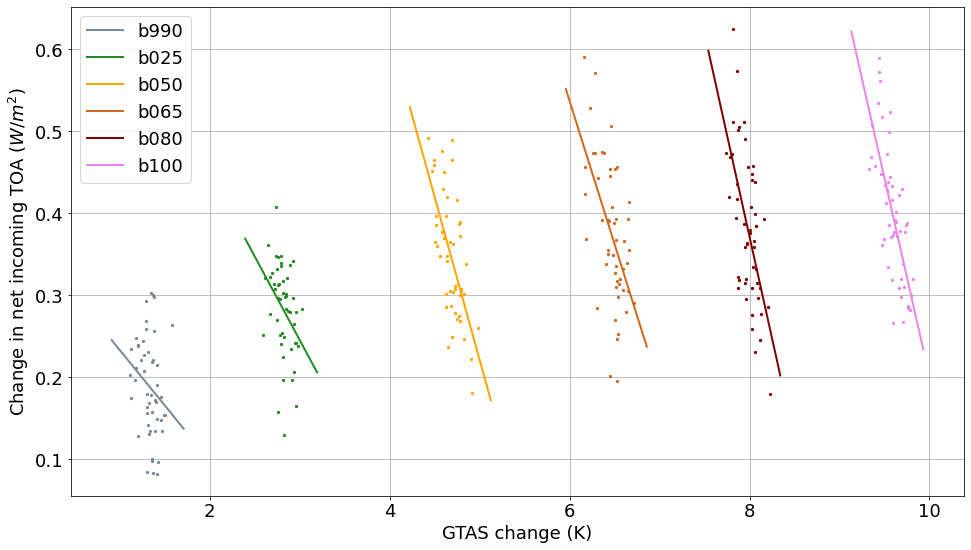

In [12]:
fb_fin = dict()
init = 500
fin = 1000

print(f'Using {var}, nx {nx}!')

fig, ax = plt.subplots(figsize = (16,9))

for ru, col in zip(allru[2:-1], colors[2:-1]):
    #toa = glomeans[(ru, var)][1][init:fin]
    toa = fluxes[(ru, var)][init:fin]
    toa_anom = toa #- np.mean(toa[:10])
    #toa_anom = ctl.running_mean(toa_anom, 5, remove_nans = True)[::5]

    #tas = glomeans[(ru, 'tas')][1][init:fin]
    tas = fluxes[(ru, 'tas')][init:fin]
    tas_anom = tas #- tas[:10].mean()
    #tas_anom = ctl.running_mean(tas_anom, 5, remove_nans = True)[::5]

    # ordering for temp # NO! this is different than removing the fast manifold
    #gino = np.argsort(tas_anom)
    #tas_anom = tas_anom[gino]
    #toa_anom = toa_anom[gino]

    toa_anom = np.mean(np.split(toa_anom, int(len(toa_anom)/nx)), axis = 1)
    tas_anom = np.mean(np.split(tas_anom, int(len(tas_anom)/nx)), axis = 1)
    ax.scatter(tas_anom, toa_anom, color = col, s = 5)

    x_nu = np.arange(tas_anom.min()-0.2, tas_anom.max()+0.2, 0.1)
    # coeffs2, covmat = np.polyfit(tas_anom, toa_anom, deg = 2, cov = True)
    # toaint(coeffs2)
    # fitted = np.polyval(coeffs2, x_nu)
    # ax.plot(x_nu, fitted, color = col, ls = ':')

    coeffs, covmat = np.polyfit(tas_anom, toa_anom, deg = 1, cov = True)
    fitted = np.polyval(coeffs, x_nu)
    ax.plot(x_nu, fitted, color = col, lw = 2, label = ru)

    x_nu_ok = x_nu #+ tas[:10].mean() #- pimean['tas']
    # ax2.plot(x_nu_ok, coeffs2[1]+2*coeffs2[0]*x_nu, color = col, lw = 2, label = ru)

    m, c, err_m, err_c = ctl.linear_regre_witherr(tas_anom, toa_anom)
    stron = r'{}: $\lambda = {:5.3f} \pm {:5.3f} \ W/m^2/K$'.format(ru, m, err_m)
    print(stron)
    #ax.text(-0.3, -1.5-(allru.index(ru)-2)*0.2, stron, fontsize = 14)

    fb_fin[ru] = (m, err_m)

ax.grid()
ax.legend()
#ctl.custom_legend(fig, colors[2:-1], allru[2:-1])
#ax.subplots_adjust(bottom = 0.2)
ax.set_xlabel('GTAS change (K)')
ax.set_ylabel(r'Change in net incoming TOA ($W/m^2$)')
fig.savefig(cart_out + 'feedback_evolution_500-1000.pdf'.format(var))

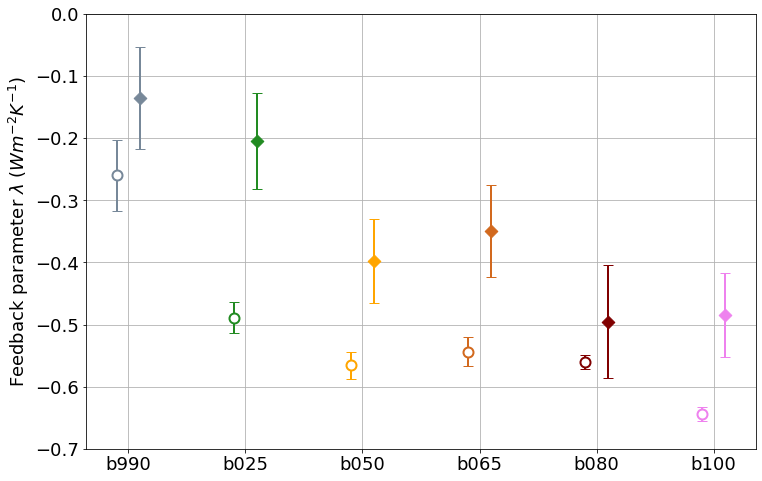

In [13]:
fig, ax = plt.subplots(figsize = (12,8))

for i, (ru, col) in enumerate(zip(allru[2:-1], colors[2:-1])):
    ax.errorbar(i-0.1, fb_init[ru][0], yerr = fb_init[ru][1], color = col, capsize = 5, zorder = 6, lw = 2, ls = '-')
    ax.scatter(i-0.1, fb_init[ru][0], color = col, s = 100, label = ru, marker = 'o', facecolor = 'white', zorder = 10, lw = 2)

    ax.errorbar(i+0.1, fb_fin[ru][0], yerr = fb_fin[ru][1], color = col, capsize = 5, zorder = 6, lw = 2, ls = '--')
    ax.scatter(i+0.1, fb_fin[ru][0], color = col, s = 80, label = ru, marker = 'D')

ax.grid()

ax.set_xticks(np.arange(6))
ax.set_xticklabels(allru[2:-1])
ax.set_ylim([min(ax.get_ylim()[0], -0.7), 0.])

ax.set_ylabel(r'Feedback parameter $\lambda$ ($W m^{-2} K^{-1}$)')
fig.savefig(cart_out + 'feedback_evolution_start-end.pdf'.format(var))

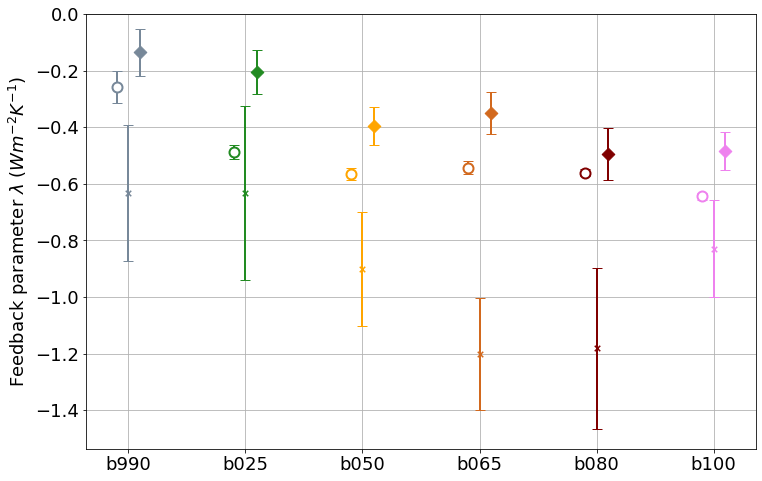

In [41]:
fig, ax = plt.subplots(figsize = (12,8))

for i, (ru, col) in enumerate(zip(allru[2:-1], colors[2:-1])):
    ax.errorbar(i-0.1, fb_init[ru][0], yerr = fb_init[ru][1], color = col, capsize = 5, zorder = 6, lw = 2, ls = '-')
    ax.scatter(i-0.1, fb_init[ru][0], color = col, s = 100, label = ru, marker = 'o', facecolor = 'white', zorder = 10, lw = 2)

    ax.errorbar(i+0.1, fb_fin[ru][0], yerr = fb_fin[ru][1], color = col, capsize = 5, zorder = 6, lw = 2, ls = '--')
    ax.scatter(i+0.1, fb_fin[ru][0], color = col, s = 80, label = ru, marker = 'D')

    ax.errorbar(i, fb_start20[ru][0], yerr = fb_start20[ru][1], color = col, capsize = 5, zorder = 6, lw = 2, ls = '--')
    ax.scatter(i, fb_start20[ru][0], color = col, s = 30, label = ru, marker = 'x')

ax.grid()

ax.set_xticks(np.arange(6))
ax.set_xticklabels(allru[2:-1])
ax.set_ylim([None, 0.])

ax.set_ylabel(r'Feedback parameter $\lambda$ ($W m^{-2} K^{-1}$)')
fig.savefig(cart_out + 'feedback_evolution_start-end_start20.pdf'.format(var))

0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100
0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100
0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100
0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100
0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100
0 20
10 30
20 40
30 50
40 60
50 70
60 80
70 90
80 100


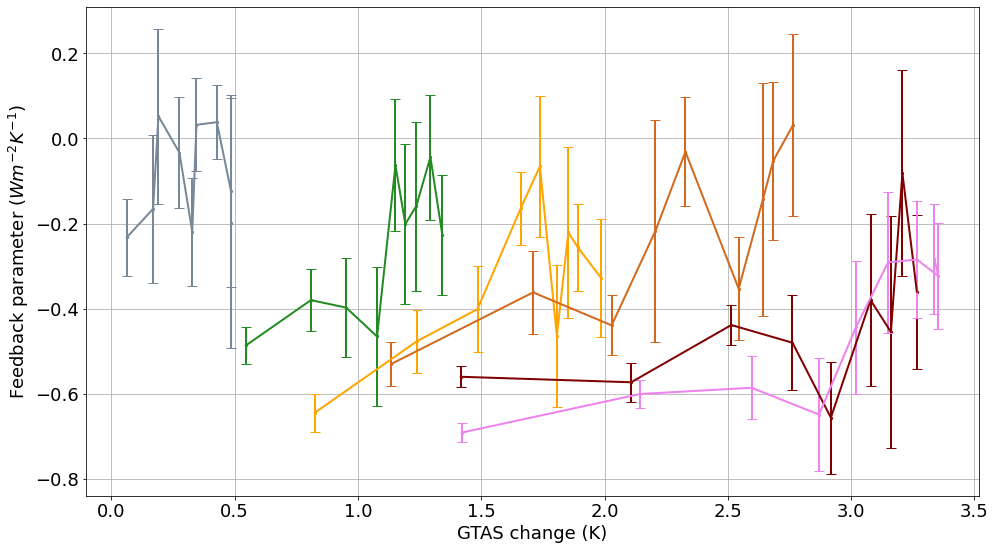

In [47]:
fb_evol = dict()
fb_evol_err = dict()
tas_evol = dict()
toa_evol = dict()
nx = 10

for ru, col in zip(allru[2:-1], colors[2:-1]):
    #toa = glomeans[(ru, var)][1]
    toa = fluxes[(ru, 'net_toa_corr')]
    toa_anom = toa-np.mean(toa[:10])

    tas = fluxes[(ru, 'tas')]
    #tas = glomeans[(ru, 'tas')][1]
    tas_anom = tas - tas[:10].mean()

    toa_anom = np.mean(np.split(toa_anom, int(len(toa_anom)/nx)), axis = 1)
    tas_anom = np.mean(np.split(tas_anom, int(len(tas_anom)/nx)), axis = 1)
    
    fb_evol[ru] = []
    fb_evol_err[ru] = []

    tas_evol[ru] = []
    toa_evol[ru] = []

    init = 0
    fin = int(200/nx)
    while fin <= int(1000/nx):
        #print(init, fin)
        m, c, err_m, err_c = ctl.linear_regre_witherr(tas_anom[init:fin], toa_anom[init:fin])
        fb_evol[ru].append(m)
        fb_evol_err[ru].append(err_m)
        tas_evol[ru].append(np.mean(tas_anom[init:fin]))
        toa_evol[ru].append(np.mean(toa_anom[init:fin]))

        init += int(100/nx)
        fin += int(100/nx)


fig, ax = plt.subplots(figsize = (16,9))

for ru, col in zip(allru[2:-1], colors[2:-1]):
    ax.errorbar(tas_evol[ru], fb_evol[ru], yerr = fb_evol_err[ru], color = col, capsize = 5, zorder = 6, lw = 2)
    ax.scatter(tas_evol[ru], fb_evol[ru], color = col, s = 5, label = ru)

ax.grid()
#ax.legend()
#ctl.custom_legend(fig, colors[2:-1], allru[2:-1])
#ax.subplots_adjust(bottom = 0.2)
ax.set_xlabel('GTAS change (K)')
ax.set_ylabel(r'Feedback parameter ($W m^{-2} K^{-1}$)')
fig.savefig(cart_out + 'feedback_evolution_temp.pdf'.format(var))

In [5]:
###
cart_run = '/home/fabiano/Research/git/ece_runtime/run/'
masfi = cart_run + 'masks.nc'
cose = xr.load_dataset(masfi)
land_mask = ~cose['RnfA.msk'].values.astype('bool') # 1 over land

In [10]:
# cart_prsn = '/home/fabiano/work_big/cineka_bkp_0923/stabilization-*{}/r1i1p1f1/Amon/prsn/'

# prsn = dict()
# for ru in allru[2:-1]:
#     print(ru)
#     coso = xr.open_mfdataset(cart_prsn.format(ru[-3:]) + 'prsn*nc', use_cftime = True)['prsn']
#     cosoyr = coso.groupby('time.year').mean()
#     cosoglo = ctl.global_mean(cosoyr)
#     prsn[ru] = cosoglo.compute()


In [11]:
def roundlat(ds, ndec = 10):
    ds = ds.assign_coords(lat = ds.lat.round(ndec))
    return ds

In [9]:
cosoyr

<xarray.DataArray 'prsn' (year: 1000, lat: 258, lon: 512)>
dask.array<stack, shape=(1000, 258, 512), dtype=float32, chunksize=(1, 258, 512), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2985 2986 2987 2988 2989

In [12]:
cart_prsn = '/home/fabiano/work_big/cineka_bkp_0923/stabilization-*{}/r1i1p1f1/Amon/prsn/'

prsn = dict()
for ru in allru[2:-1]:
    print(ru)
    coso = xr.open_mfdataset(cart_prsn.format(ru[-3:]) + 'prsn*nc', use_cftime = True, preprocess=ctl.roundlat)['prsn']
    cosoyr = coso.groupby('time.year').mean()

    glomean_oce = ctl.global_mean(cosoyr, mask = ~land_mask).compute()
    glomean_land = ctl.global_mean(cosoyr, mask = land_mask).compute()
    cosoglo = ctl.global_mean(cosoyr).compute()

    prsn[ru] = cosoglo
    prsn[(ru, 'oce')] = glomean_oce
    prsn[(ru, 'land')] = glomean_land

b990


b025
b050
b065
b080
b100


In [12]:
# cart_prsn = '/home/fabiano/work_big/cineka_bkp_0923/stabilization-*{}/r1i1p1f1/Amon/prsn/'

# ru = 'b990'
# coso = xr.open_mfdataset(cart_prsn.format(ru[-3:]) + 'prsn*nc', use_cftime = True, preprocess=roundlat)['prsn']
# cosoyr = coso.groupby('time.year').mean()
# cosoglo = ctl.global_mean(cosoyr)
# prsn[ru] = cosoglo.compute()

In [16]:
pickle.dump(prsn, open('/home/fabiano/Research/lavori/BOTTINO/nonlin_evol_1000/prsn_all.p', 'wb'))

In [14]:
prsn = pickle.load(open('/home/fabiano/Research/lavori/BOTTINO/nonlin_evol_1000/prsn_all.p', 'rb'))

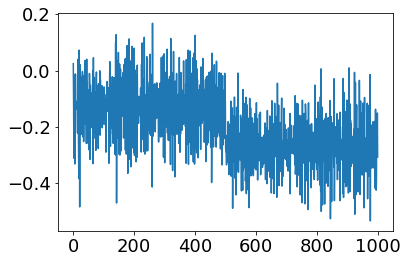

In [15]:
%matplotlib inline
#plt.plot(prsn['b990'])

ru = 'b990'
plt.plot(glomeans[(ru, 'net_toa')][1]-glomeans[(ru, 'net_srf')][1]+prsn[ru]*334000)

In [15]:
# Missing year 2757 in b100

# anni = list(prsn['b100'].year.values)
# for uu in range(2100, 3100):
#     if uu not in anni:
#         print(uu)

# pio = xr.concat([prsn['b100'].sel(year = slice(0, 2757)), prsn['b100'].sel(year = 2756), prsn['b100'].sel(year = slice(2757, None))], dim = 'year')
# prsn['b100'] = pio

# pio = xr.concat([prsn[('b100', 'oce')].sel(year = slice(0, 2757)), prsn[('b100', 'oce')].sel(year = 2756), prsn[('b100', 'oce')].sel(year = slice(2757, None))], dim = 'year')
# prsn[('b100', 'oce')] = pio

# pio = xr.concat([prsn[('b100', 'land')].sel(year = slice(0, 2757)), prsn[('b100', 'land')].sel(year = 2756), prsn[('b100', 'land')].sel(year = slice(2757, None))], dim = 'year')
# prsn[('b100', 'land')] = pio


In [ ]:
%matplotlib inline

In [ ]:
# from importlib import reload
# reload(ctl)

libgfortran.so.3: cannot open shared object file: No such file or directory
No DISPLAY variable set. Switching to agg backend


<module 'climtools_lib' from '/home/fabiano/Research/git/ClimTools/climtools_lib.py'>

b990
b025
b050
b065
b080
b100


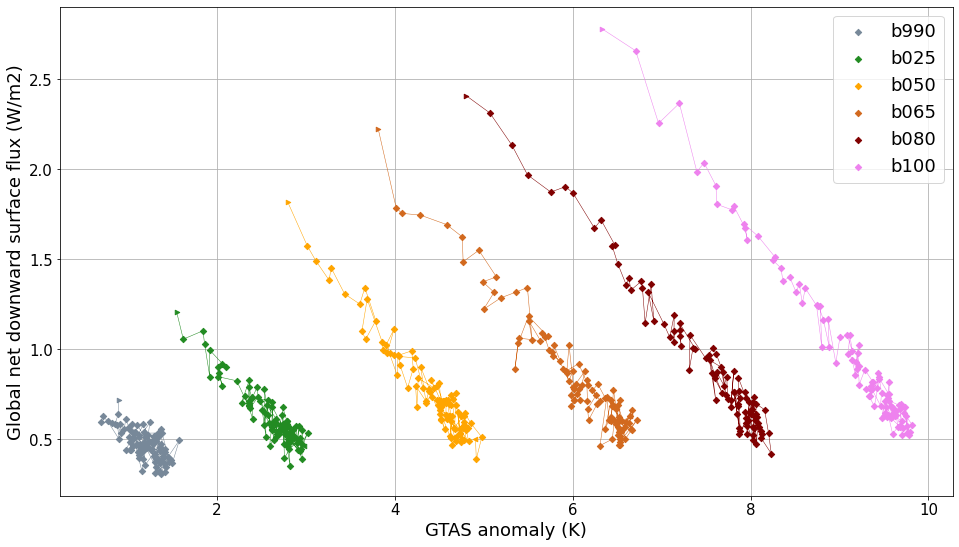

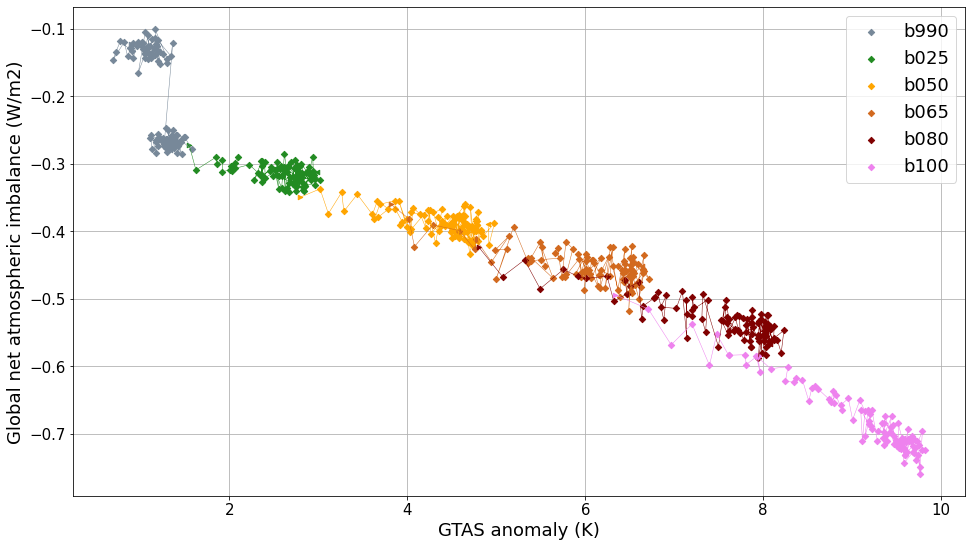

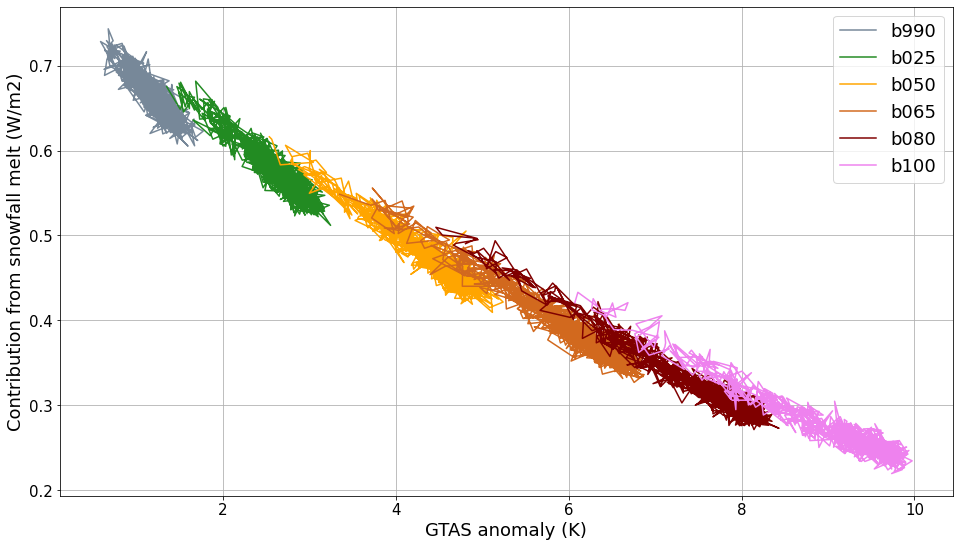

In [17]:
fig_greg_srf, ax_greg_srf = plt.subplots(figsize = (16,9))
fig_greg_inatm, ax_greg_inatm = plt.subplots(figsize = (16,9))
fig_prsn, ax_prsn = plt.subplots(figsize = (16,9))

for ru, col in zip(allru[2:-1], colors[2:-1]):
    print(ru)
    #if (ru, 'net_toa') in glomeans:
    #    ctl.gregplot_on_ax(ax_greg, glomeans[(ru, 'tas')][1]-pimean['tas'], glomeans[(ru, 'net_toa')][1], color = col, label = ru, calc_ERF = False, calc_ECS = False, nyea = 10, point_dim = 20)
    netsrf = glomeans[(ru, 'net_srf')][1] - prsn[ru]*334000

    ax_prsn.plot(glomeans[(ru, 'tas')][1]-pimean['tas'], prsn[ru]*334000., color = col, label = ru)

    if (ru, 'net_srf') in glomeans:
        ctl.gregplot_on_ax(ax_greg_srf, glomeans[(ru, 'tas')][1]-pimean['tas'], netsrf, color = col, label = ru, calc_ERF = False, calc_ECS = False, nyea = 10, point_dim = 20)#, ylim = (0., None))

    if (ru, 'net_toa') in glomeans and (ru, 'net_srf') in glomeans:
        ctl.gregplot_on_ax(ax_greg_inatm, glomeans[(ru, 'tas')][1]-pimean['tas'], glomeans[(ru, 'net_toa')][1]-netsrf, color = col, label = ru, calc_ERF = False, calc_ECS = False, nyea = 10, point_dim = 20)#, ylim = (0., None))

    
for ax in [ax_prsn, ax_greg_srf, ax_greg_inatm]:
    ax.legend()
    ax.grid()
    ax.set_xlabel('GTAS anomaly (K)')

ax_prsn.set_ylabel('Contribution from snowfall melt (W/m2)')
ax_greg_srf.set_ylabel('Global net downward surface flux (W/m2)')
ax_greg_inatm.set_ylabel('Global net atmospheric imbalance (W/m2)')

fig_prsn.savefig(cart_out + 'bottino_prsn_1000.pdf')
fig_greg_srf.savefig(cart_out + 'bottino_gregory_1000_srf_w_prsn.pdf')
fig_greg_inatm.savefig(cart_out + 'bottino_gregory_1000_inatm_w_prsn.pdf')


In [7]:
glomeans[('b025', 'net_srf')][1]

array([2.36578943, 1.80509072, 1.69002414, 1.93269206, 2.08750839,
       1.2925119 , 2.36534521, 1.8147236 , 1.8433245 , 1.48694521,
       1.09385144, 2.2794907 , 1.7721232 , 1.52607288, 1.82696414,
       1.44311984, 1.94859261, 1.88996275, 1.72458745, 1.60125441,
       2.24283047, 1.5377442 , 1.38117881, 2.26551402, 1.89446459,
       1.21523881, 2.02350788, 1.87921527, 1.43190716, 1.56460289,
       1.83699166, 1.28358233, 2.21268971, 1.36318523, 2.08636405,
       1.74402036, 1.49591028, 1.33512668, 1.54412877, 1.82888788,
       1.33304942, 0.86564402, 2.05469803, 2.10233357, 1.22499837,
       1.70268079, 1.97795144, 1.30092197, 1.49233672, 0.70979277,
       1.84671579, 1.64329826, 1.75707433, 1.58262329, 1.04103772,
       2.28169055, 1.59158086, 1.80643272, 0.95114351, 1.86675233,
       1.9624384 , 1.52445459, 1.13216536, 1.81732707, 1.79888   ,
       1.48068076, 1.2726366 , 0.91804869, 1.80205287, 1.69322749,
       2.00367177, 1.33446483, 1.17968312, 1.65871544, 1.41275

In [ ]:
/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/piControl/r1i1p1f1/Amon/prsn